# Celltype auto annotation with SCSA
Single-cell transcriptomics allows the analysis of thousands of cells in a single experiment and the identification of novel cell types, states and dynamics in a variety of tissues and organisms. Standard experimental protocols and analytical workflows have been developed to create single-cell transcriptomic maps from tissues.

This tutorial focuses on how to interpret this data to identify cell types, states, and other biologically relevant patterns with the goal of creating annotated cell maps.

Paper: [SCSA: A Cell Type Annotation Tool for Single-Cell RNA-seq Data](https://doi.org/10.3389/fgene.2020.00490)

Code: https://github.com/bioinfo-ibms-pumc/SCSA

Colab_Reproducibility：https://colab.research.google.com/drive/1BC6hPS0CyBhNu0BYk8evu57-ua1bAS0T?usp=sharing

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA can't be used in rare celltype annotations
  </p>
</div>

![scsa](https://www.frontiersin.org/files/Articles/524690/fgene-11-00490-HTML/image_m/fgene-11-00490-g001.jpg)

In [1]:
# !pip install omicverse
# !pip install torch_geometric
# !pip install pymde

**You must restart the program(ctrl+m+.) in order to import the accurate version of matplotlib.**

In [2]:
import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.5.7
scanpy version:1.9.6


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [3]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [6]:
adata = sc.read_10x_mtx(
    'data/Healthy_PBMC_Human/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-Healthy_PBMC_Human-filtered_feature_bc_matrix-matrix.h5ad


## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation.

But if you want to experience step-by-step preprocessing, we also provide more detailed preprocessing steps here, please refer to our [preprocess chapter](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess/) for a detailed explanation.

We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [7]:
#adata=ov.single.scanpy_lazy(adata)

#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson', n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled', n_pcs=50)

#Neighbourhood graph construction
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
sc.tl.leiden(adata)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 10548
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 16375 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 55.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.2%
    Scrublet finished (0:00:07)
Cells retained after scrublet: 10071, 477 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tr

AnnData object with n_obs × n_vars = 8557 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'leiden'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [8]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='cellmarker',
                          tissue='All',
)

......Loading dataset from temp/pySCSA_2023_v2_plus.db


In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.

`rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`, if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`

In [9]:
anno=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:08)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 218
Other Gene number: 6118
Cluster 1 Gene number: 1959
Other Gene number: 5986
Cluster 10 Gene number: 123
Other Gene number: 6140
Cluster 11 Gene number: 256
Other Gene number: 6140
Cluster 12 Gene number: 1910
Other Gene number: 6023
Cluster 13 Gene number: 529
Other Gene number: 6055
Cluster 14 Gene number: 1615
Other Gene number: 5950
Cluster 15 Gene number: 3058
Other Gene number: 5343
Cluster 16 Gene number: 1072
Other Gene number: 6097
Cluster 17 Gene number: 499
Other Gene number: 6063
Cluster 2 Gene number: 316
Other Gene number: 6103
Cluster 3 Gene number: 27

We can query only the better annotated results

In [10]:
scsa.cell_auto_anno(adata,key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


We can also use `panglaodb` as target to annotate the celltype

In [11]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'

)

In [12]:
res=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:08)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 218
Other Gene number: 2191
Cluster 1 Gene number: 1959
Other Gene number: 2136
Cluster 10 Gene number: 123
Other Gene number: 2209
Cluster 11 Gene number: 256
Other Gene number: 2212
Cluster 12 Gene number: 1910
Other Gene number: 2164
Cluster 13 Gene number: 529
Other Gene number: 2142
Cluster 14 Gene number: 1615
Other Gene number: 2141
Cluster 15 Gene number: 3058
Other Gene number: 2053
Cluster 16 Gene number: 1072
Other Gene number: 2191
Cluster 17 Gene number: 499
Other Gene number: 2177
Cluster 2 Gene number: 316
Other Gene number: 2190
Cluster 3 Gene number: 27

We can query only the better annotated results

In [13]:
scsa.cell_anno_print()

Cluster:0	Cell_type:T Cells|T Memory Cells	Z-score:3.789|3.7
Cluster:1	Cell_type:Monocytes|Macrophages	Z-score:3.919|3.464
Cluster:2	Cell_type:T Cells|T Memory Cells	Z-score:3.9|3.763
Cluster:3	Cell_type:T Cells|NK Cells	Z-score:4.33|3.601
Cluster:4	Cell_type:Monocytes|Neutrophils	Z-score:3.709|2.967
Cluster:5	Cell_type:B Cells|Plasma Cells	Z-score:5.698|5.025
Cluster:6	Cell_type:NK Cells|T Cells	Z-score:5.091|3.062
Cluster:7	Cell_type:NK Cells|T Cells	Z-score:3.751|3.58
Cluster:8	Cell_type:Dendritic Cells|Monocytes	Z-score:3.985|3.603
Cluster:9	Cell_type:T Cells|NK Cells	Z-score:4.114|3.933
Cluster:10	Cell_type:T Cells|T Helper Cells	Z-score:3.18|3.045
Cluster:11	Cell_type:T Cells|NK Cells	Z-score:3.815|3.811
Cluster:12	Cell_type:Monocytes|Macrophages	Z-score:3.972|3.299
Nice:Cluster:13	Cell_type:Platelets	Z-score:9.143
Cluster:14	Cell_type:Plasmacytoid Dendritic Cells|Dendritic Cells	Z-score:6.549|3.872
Cluster:15	Cell_type:Pluripotent Stem Cells|Reticulocytes	Z-score:5.424|4.118
Clu

In [14]:
scsa.cell_auto_anno(adata,key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


Here, we introduce the dimensionality reduction visualisation function `ov.utils.embedding`, which is similar to `scanpy.pl.embedding`, except that when we set `frameon='small'`, we scale the axes to the bottom-left corner and scale the colourbar to the bottom-right corner.

- adata: the anndata object
- basis: the visualized embedding stored in adata.obsm
- color: the visualized obs/var
- legend_loc: the location of legend, if you set None, it will be visualized in right.
- frameon: it can be set `small`, False or None
- legend_fontoutline: the outline in the text of legend.
- palette: Different categories of colours, we have a number of different colours preset in omicverse, including `ov.utils.palette()`, `ov.utils.red_color`, `ov.utils.blue_color`, `ov.utils.green_color`, `ov. utils.orange_color`. The preset colours can help you achieve a more beautiful visualisation.

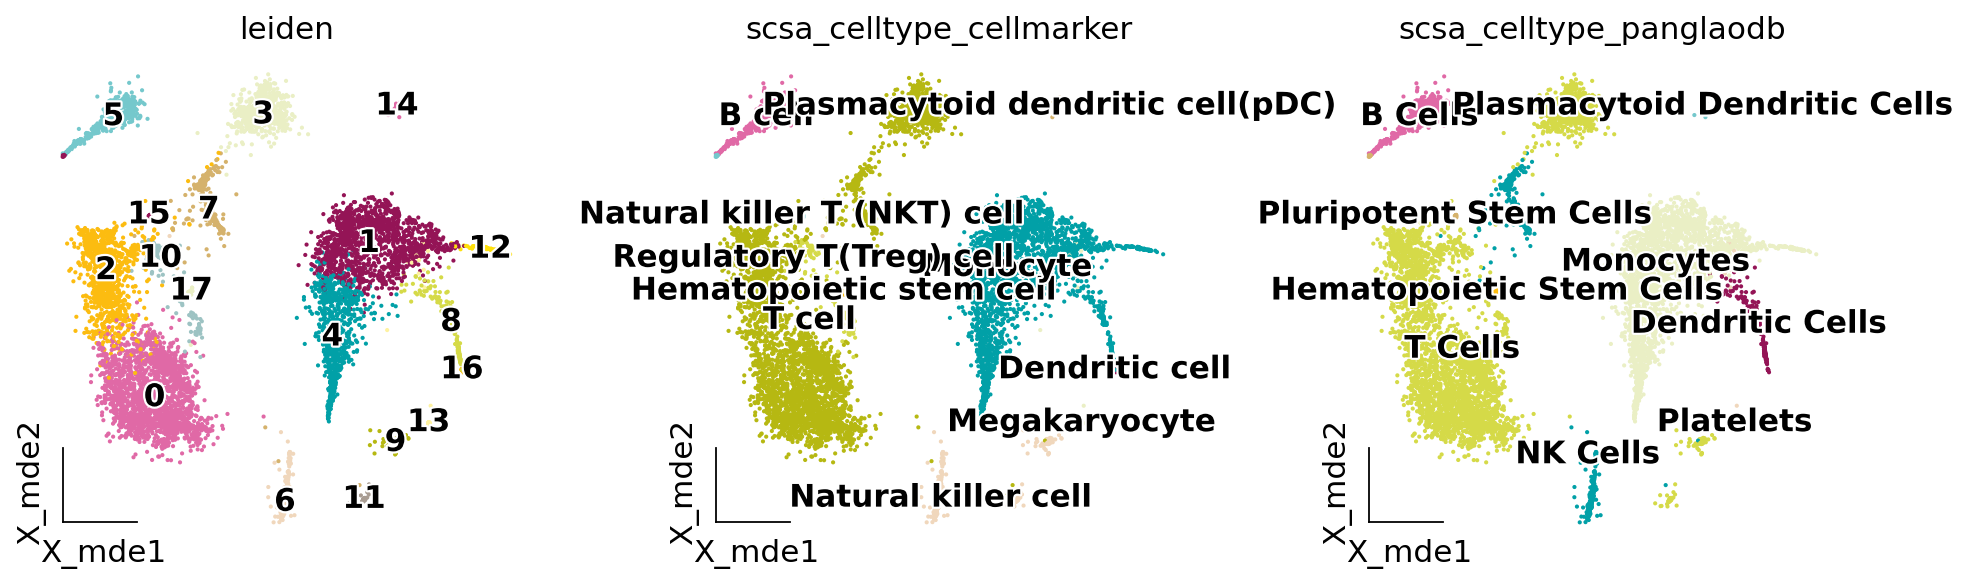

In [15]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['leiden','scsa_celltype_cellmarker','scsa_celltype_panglaodb'],
                   legend_loc='on data',
                   frameon='small',
                   legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

If you want to draw stacked histograms of cell type proportions, you first need to colour the groups you intend to draw using `ov.utils.embedding`. Then use `ov.utils.plot_cellproportion` to specify the groups you want to plot, and you can see a plot of cell proportions in the different groups

In [16]:
# adata

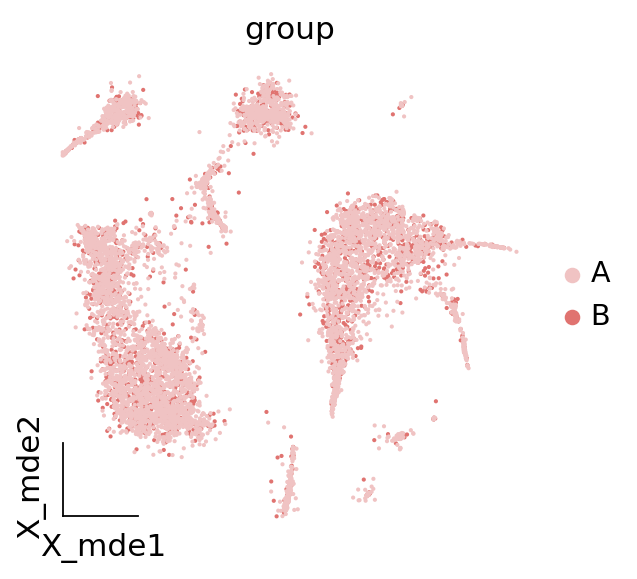

In [17]:
#Randomly designate the first 1000 cells as group B and the rest as group A
adata.obs['group']='A'
adata.obs.loc[adata.obs.index[:2500],'group']='B'
#Colored
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['group'],
                   frameon='small',legend_fontoutline=2,
                   palette=ov.utils.red_color,
                  )

(<Figure size 160x320 with 1 Axes>,
 <AxesSubplot: xlabel='group', ylabel='Cells per Stage'>)

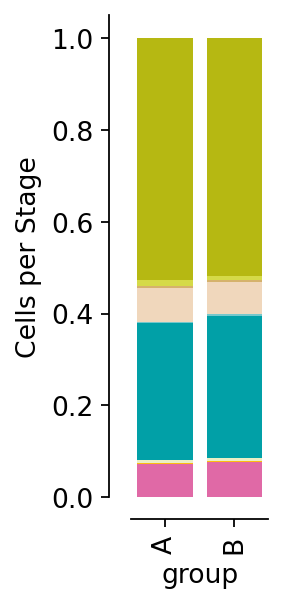

In [18]:
ov.utils.plot_cellproportion(adata=adata,celltype_clusters='scsa_celltype_cellmarker',
                    visual_clusters='group',
                    visual_name='group',figsize=(2,4))

Of course, we also provide another downscaled visualisation of the graph using `ov.utils.plot_embedding_celltype`

(<Figure size 960x800 with 2 Axes>,
 [<AxesSubplot: xlabel='X_mde1', ylabel='X_mde2'>, <AxesSubplot: >])

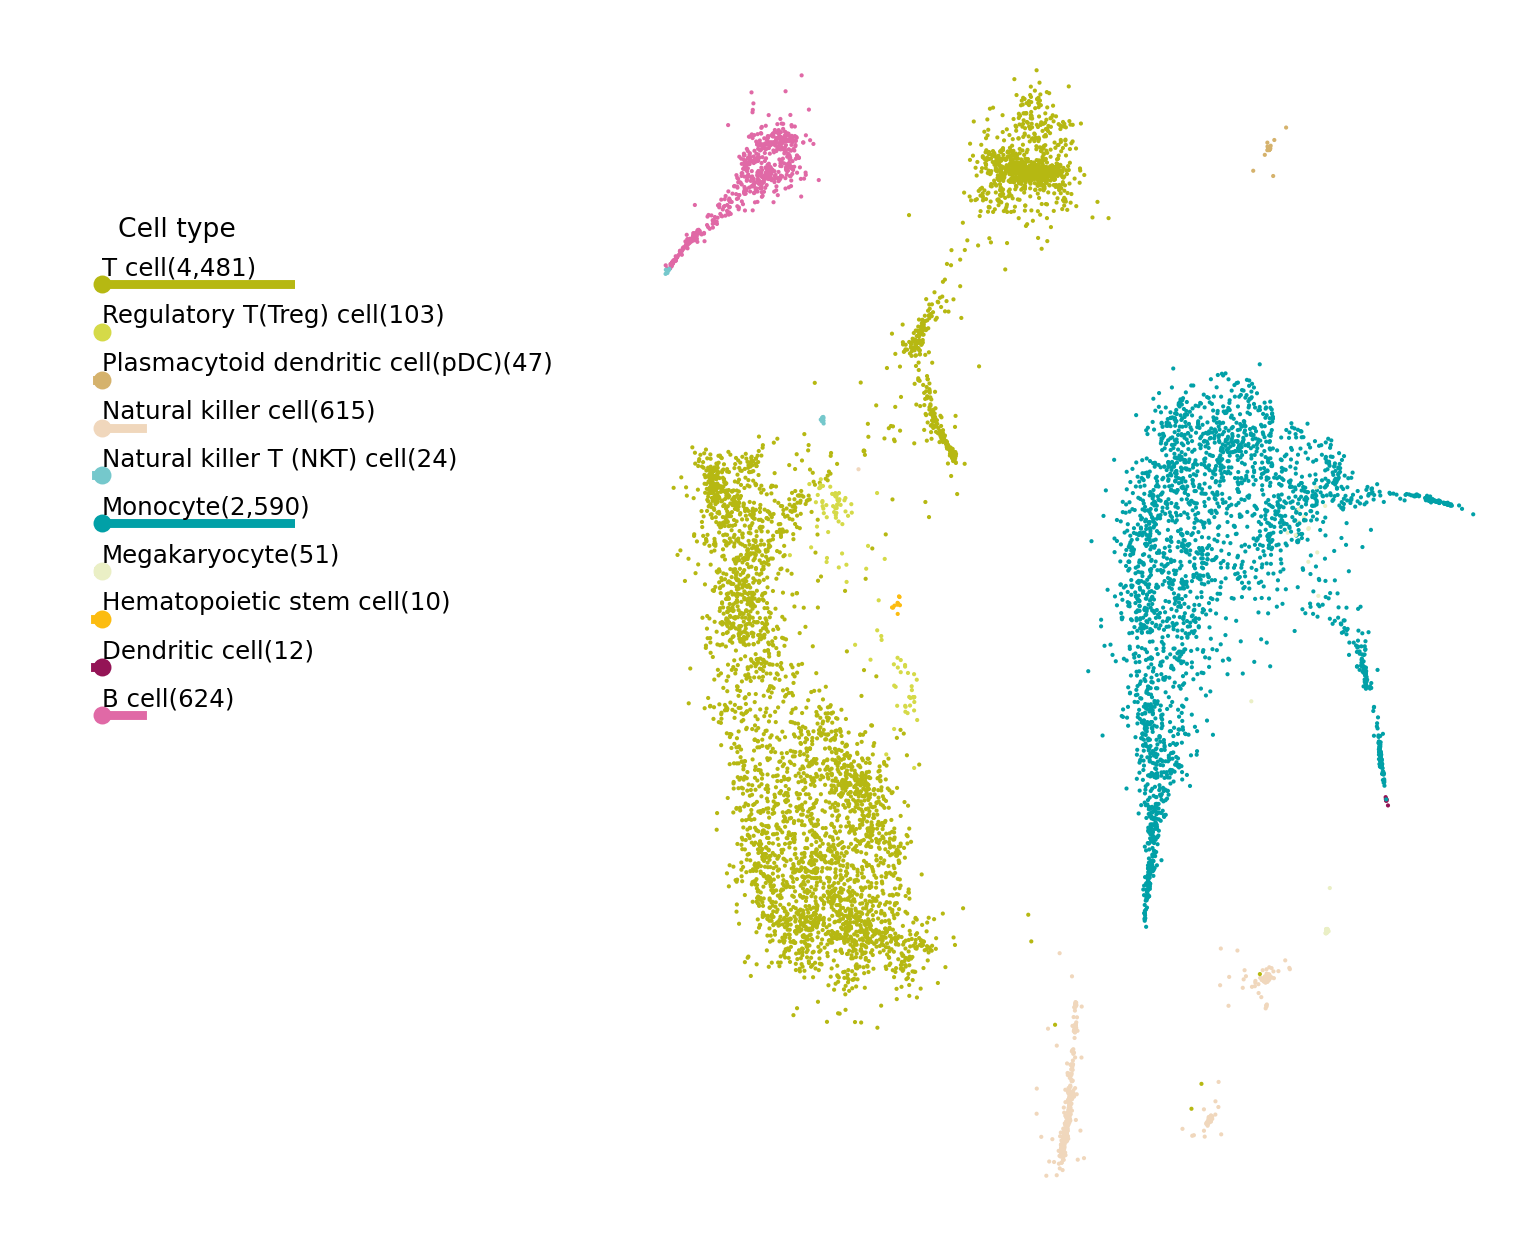

In [19]:
ov.utils.plot_embedding_celltype(adata,figsize=(12, 10),basis='X_mde',
                            celltype_key='scsa_celltype_cellmarker',
                            title='            Cell type',
                            celltype_range=(2,6),
                            embedding_range=(4,10),)

We calculated the ratio of observed to expected cell numbers (Ro/e) for each cluster in different tissues to quantify the tissue preference of each cluster (Guo et al., 2018; Zhang et al., 2018). The expected cell num- bers for each combination of cell clusters and tissues were obtained from the chi-square test. One cluster was identified as being enriched in a specific tissue if Ro/e>1.

The Ro/e function was wrote by `Haihao Zhang`.

In [20]:
roe=ov.utils.roe(adata, sample_key='group', cell_type_key='scsa_celltype_cellmarker')

chi2: 7.092067646412504, dof: 9, pvalue: 0.6275343054904703
P-value is greater than 0.05, there is no statistical significance


Text(0.5, 1.0, 'Ro/e')

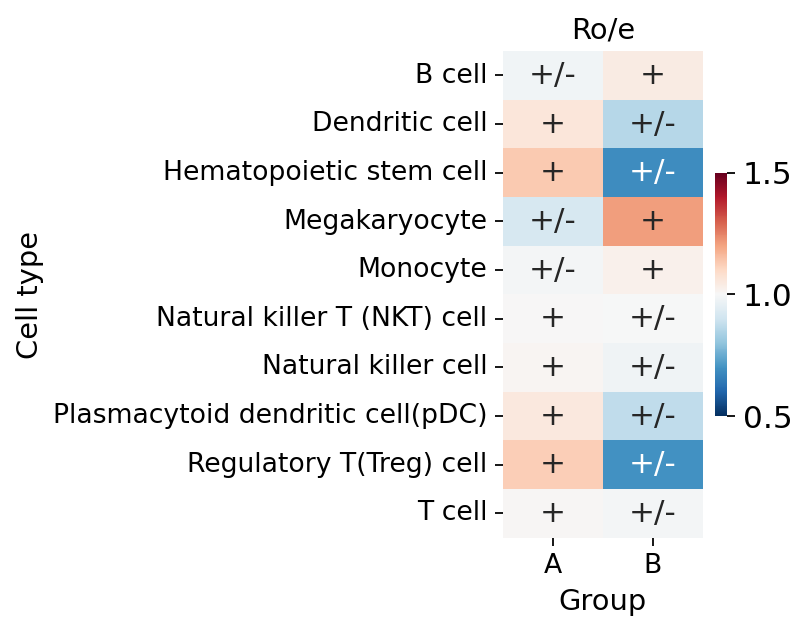

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,4))

transformed_roe = roe.copy()
transformed_roe = transformed_roe.applymap(
    lambda x: '+++' if x >= 2 else ('++' if x >= 1.5 else ('+' if x >= 1 else '+/-')))

sns.heatmap(roe, annot=transformed_roe, cmap='RdBu_r', fmt='',
            cbar=True, ax=ax,vmin=0.5,vmax=1.5,cbar_kws={'shrink':0.5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Group',fontsize=13)
plt.ylabel('Cell type',fontsize=13)
plt.title('Ro/e',fontsize=13)

In [24]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],

}

We then calculated the expression of marker genes in each cluster and the fraction

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Megakaryocyte, Dendritic cell, Monocyte, etc.


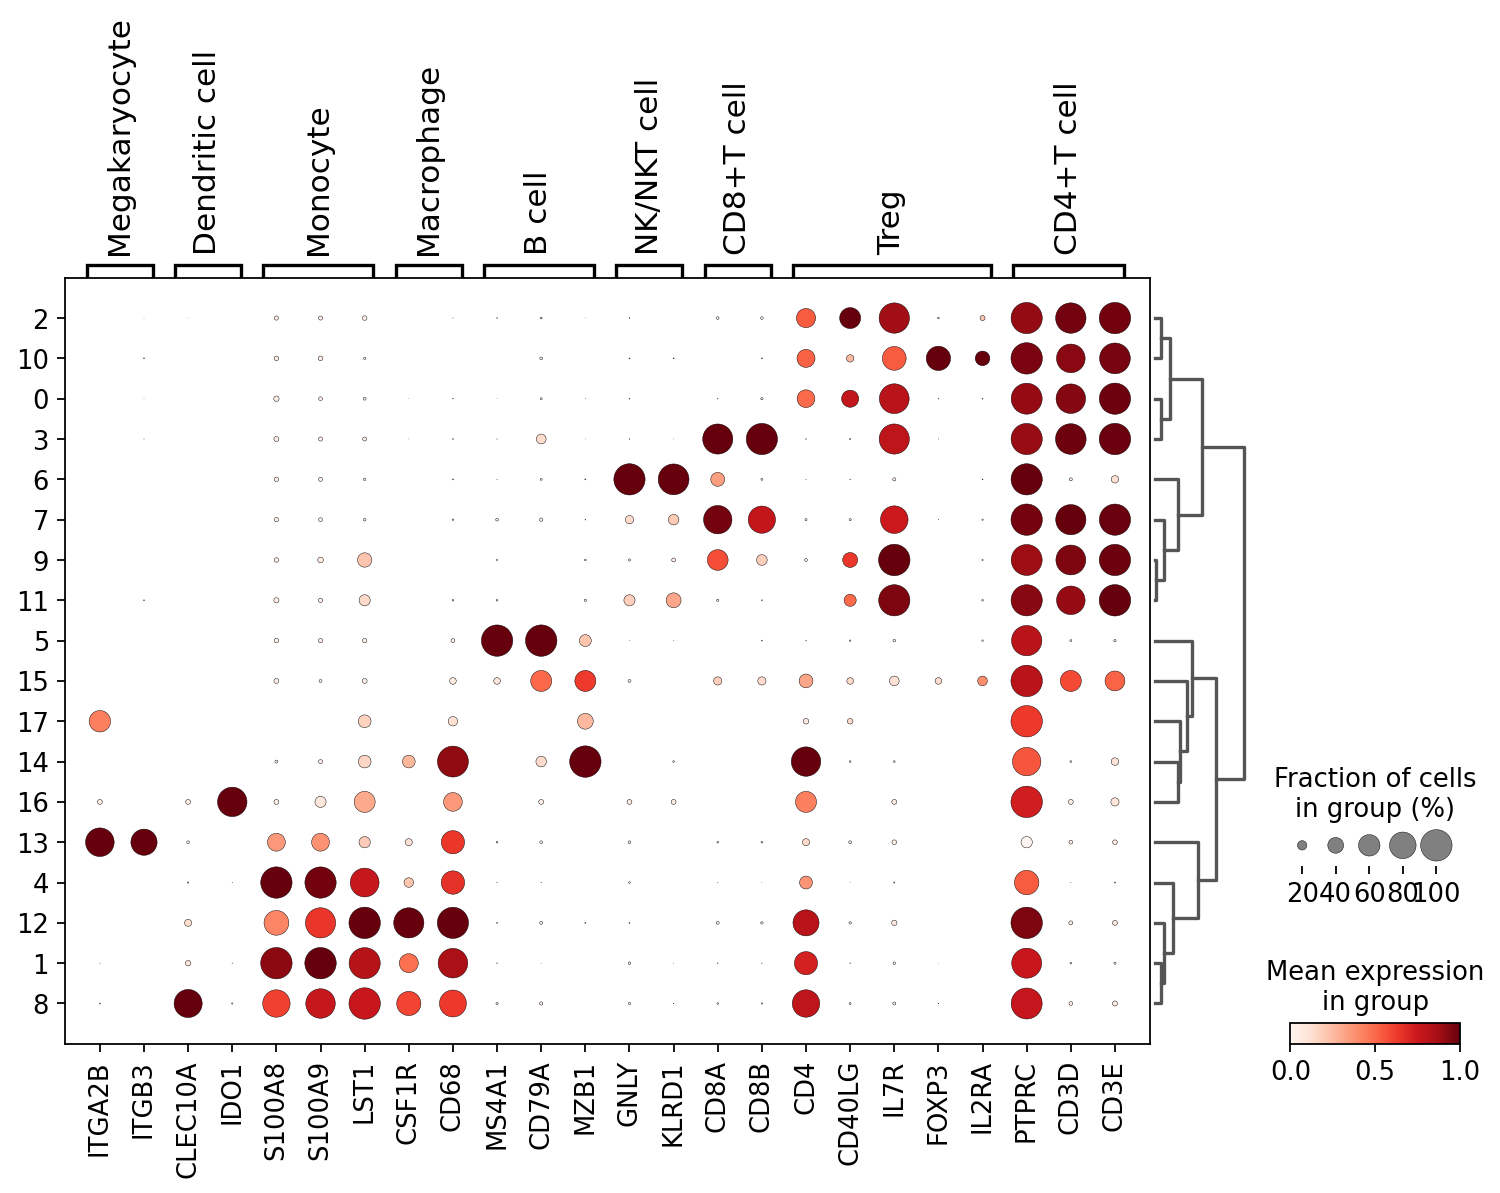

In [26]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden',
              dendrogram=True,standard_scale='var')

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [27]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'T cell',
     '2': 'Monocyte',#Germ-cell(Oid)
     '3': 'B cell',#Germ-cell(Oid)
     '4': 'T cell',
     '5': 'Macrophage',
     '6': 'NKT cells',
     '7': 'T cell',
    '8':'Monocyte',
    '9':'Dendritic cell',
    '10':'Megakaryocyte',

}
ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                       clustertype='leiden')

...cell type added to major_celltype on obs of anndata


## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [29]:
scsa.get_model_tissue()

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          